In [1]:
import os
import pickle
import random
import sys
import warnings

sys.path.append(os.path.join(".."))

import pytorch_lightning as pl
import torch
from src.model_utils import custom_multiclass_report, CroplandDataModule_LSTM, Crop_LSTM, Crop_PL
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch import nn
from torch.utils.data import DataLoader


### Read from file

In [2]:
# Read dictionary pkl file
with open(os.path.join('..', 'data', 'Processed_Files', 'X_down_all_lstm.pkl'), "rb") as fp:
    X = pickle.load(fp)

with open(os.path.join('..', 'data', 'Processed_Files', 'y_down_all_lstm.pkl'), "rb") as fp:
    y = pickle.load(fp)


In [ ]:
# initilize data module
dm = CroplandDataModule_LSTM(X=X, y=y, batch_size=32768)

# initilize model
warnings.filterwarnings("ignore")
torch.manual_seed(123)
random.seed(123)
            
network = Crop_LSTM()
model = Crop_PL(net=network)

# initilize trainer
early_stop_callback = EarlyStopping(
    monitor="val/loss", min_delta=1e-4, patience=30, verbose=True, mode="min"
)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = pl.Trainer(
    max_epochs=500,
    gpus=[1],
    precision=16,
    benchmark=True,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback, lr_monitor],
)
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 71it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.87      0.89    249306
           1       0.73      0.41      0.53     31174
           2       0.75      0.65      0.70    124554
           3       0.75      0.88      0.81    249306

    accuracy                           0.81    654340
   macro avg       0.79      0.70      0.73    654340
weighted avg       0.81      0.81      0.81    654340



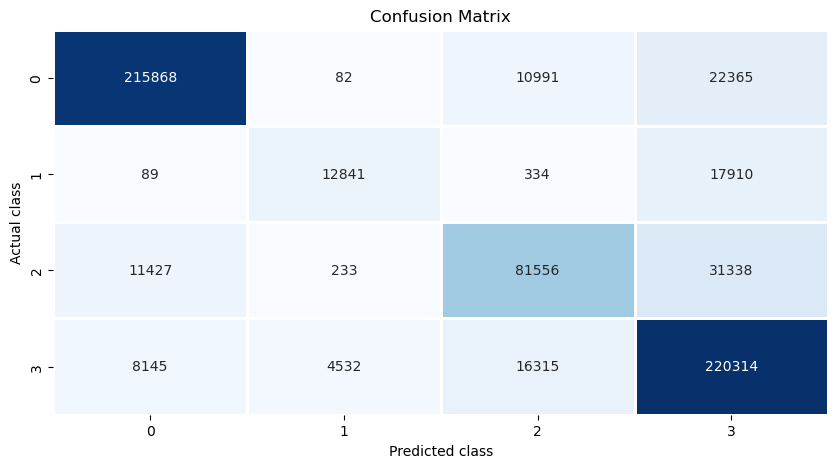

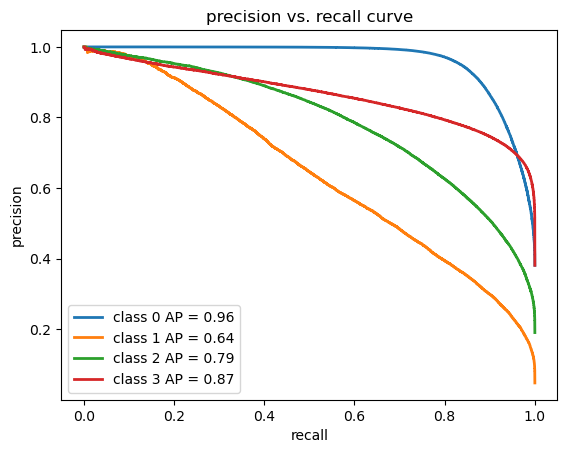

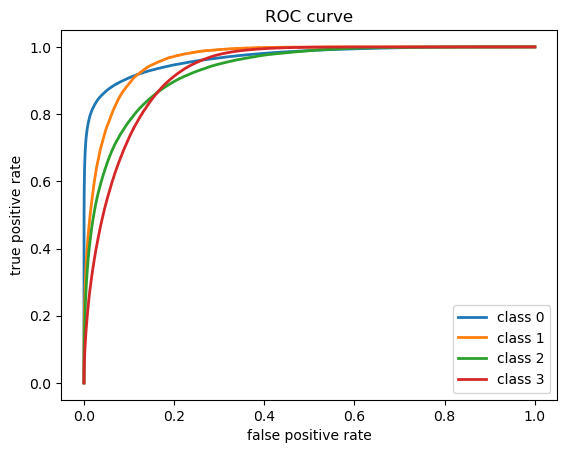

0 ROC AUC OvR: 0.9684
1 ROC AUC OvR: 0.9626
2 ROC AUC OvR: 0.9313
3 ROC AUC OvR: 0.9273
average ROC AUC OvR: 0.9474


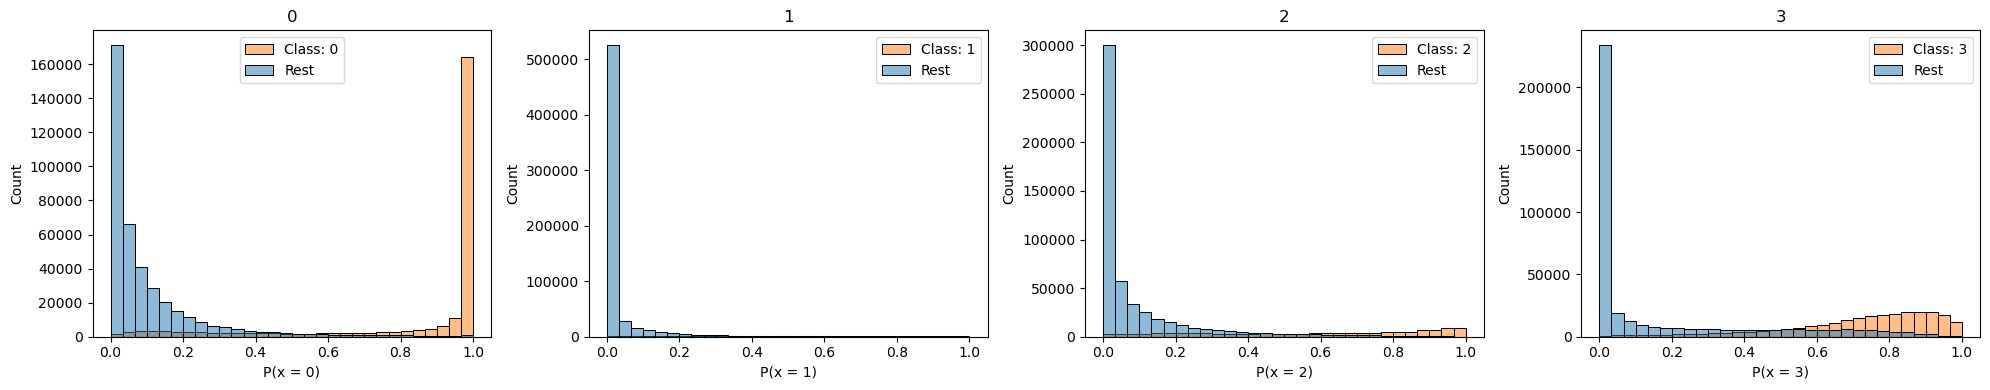

0 vs 1 ROC AUC OvO: 0.9937
1 vs 0 ROC AUC OvO: 0.9966
0 vs 2 ROC AUC OvO: 0.9557
2 vs 0 ROC AUC OvO: 0.9514
0 vs 3 ROC AUC OvO: 0.9716
3 vs 0 ROC AUC OvO: 0.9601
1 vs 2 ROC AUC OvO: 0.9819
2 vs 1 ROC AUC OvO: 0.9633
1 vs 3 ROC AUC OvO: 0.9189
3 vs 1 ROC AUC OvO: 0.7712
2 vs 3 ROC AUC OvO: 0.9073
3 vs 2 ROC AUC OvO: 0.9009
average ROC AUC OvO: 0.9394


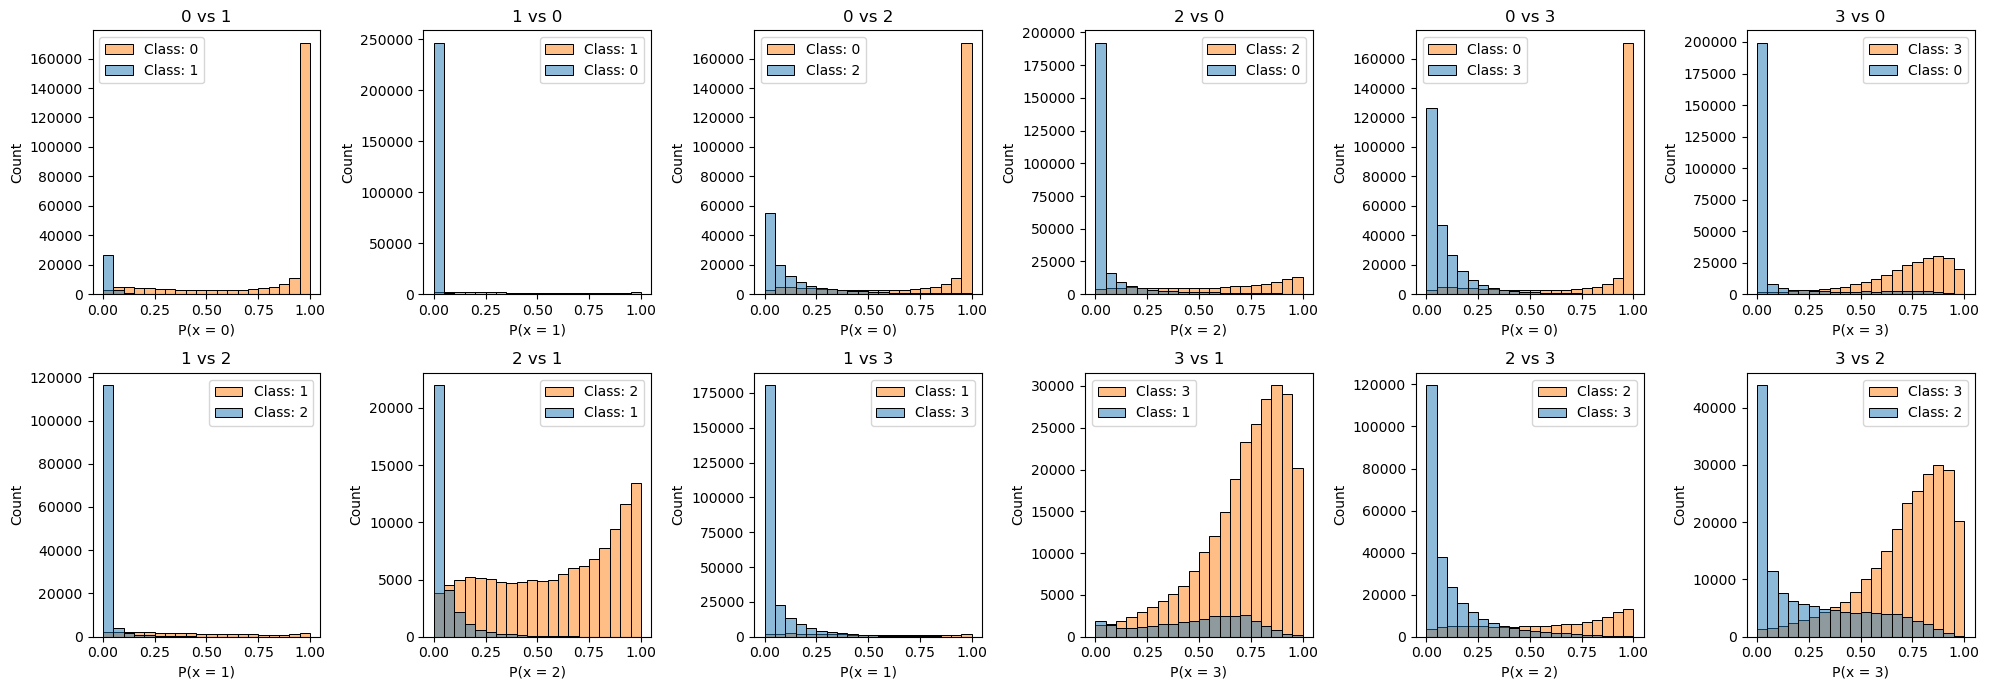

None


In [12]:
# check metrics
predictions = torch.cat(trainer.predict(model, DataLoader(dm.X_test, batch_size=2048)), dim=0)
softmax = nn.Softmax(dim=1)
yprob = softmax(predictions.float())
ypred = torch.argmax(yprob, 1)
ytest = torch.argmax(dm.y_test, 1).cpu().numpy()


print(custom_multiclass_report(ytest, ypred, yprob))


In [51]:
# Save the module to a file
torch.save(model, 'lightning_logs/version_64/my_module.pth')